In [1]:
binFile = '../../experiments/problems/bin3data/HARD5.BPP'
minBins = 56

In [2]:
import pandas as pd
import numpy as np

problemSet = pd.read_csv(binFile, header=None).values.tolist()

PROBLEM_SIZE = problemSet.pop(0)[0]
BIN_CAPACITY = problemSet.pop(0)[0]
POPULATION_SIZE = 100
TOURNAMENT_SIZE = 4
GENERATIONS = 8000
SAMPLES = 2
SAMPLE_RATE = 50

MUTATION_RATE = 0.7
CROSSOVER_RATE = 1

K = 4

items = pd.DataFrame(problemSet)
items.head()
items = np.array(items[0])
items

array([34955, 34773, 34641, 34529, 34478, 34453, 34441, 34399, 34131,
       34102, 33996, 33978, 33732, 33523, 33445, 33437, 33428, 33386,
       33338, 33183, 33140, 33108, 33076, 33005, 32986, 32984, 32859,
       32819, 32749, 32681, 32620, 32582, 32504, 32425, 32417, 31766,
       31717, 31699, 31648, 31566, 31505, 31373, 31355, 31273, 31264,
       31216, 31064, 31008, 30918, 30905, 30751, 30724, 30707, 30689,
       30617, 30592, 30519, 30459, 30315, 30297, 30279, 30246, 30246,
       30148, 30138, 30069, 29962, 29899, 29898, 29737, 29735, 29626,
       29590, 29495, 29434, 29159, 29063, 28917, 28862, 28709, 28678,
       28524, 28426, 28296, 28231, 28213, 28210, 28198, 27960, 27628,
       27622, 27502, 27473, 27345, 27330, 27323, 27301, 27240, 27120,
       27090, 27015, 26845, 26839, 26828, 26636, 26607, 26570, 26554,
       26311, 26308, 26270, 26225, 26219, 26211, 26088, 26067, 26060,
       25994, 25942, 25920, 25916, 25866, 25827, 25735, 25600, 25561,
       25504, 25443,

In [3]:
organisedChromosome = np.arange(items.size)

In [4]:
assert PROBLEM_SIZE == len(items)

In [5]:
def getMappedFitness(chromosome):
    mappedChromosome = items[chromosome]
    spaces = np.zeros(len(mappedChromosome), dtype=int)
    result = np.cumsum(mappedChromosome) - BIN_CAPACITY
    binsRequired = 0
    totalSpaceLeftOpen = 0
    while True:
        binsRequired += 1
        max_accumulate = np.maximum.accumulate(np.flipud(result <= 0))
        index_of_new_bin = PROBLEM_SIZE - next((idx for idx, val in np.ndenumerate(max_accumulate) if val == True))[0] - 1
        space_left_open = np.abs(result[index_of_new_bin])
        spaces[index_of_new_bin] = space_left_open
        result += space_left_open
        totalSpaceLeftOpen += np.power(((BIN_CAPACITY - space_left_open) / BIN_CAPACITY), K)
        if np.max(result) <= 0:
            break
        result -= BIN_CAPACITY
    return binsRequired, totalSpaceLeftOpen

In [6]:
def toStringMappedFitness(chromosome):
    result = np.cumsum(problemSet[chromosome]) - BIN_CAPACITY
    output = ''
    while True:
        max_accumulate = np.maximum.accumulate(np.flipud(result <= 0))
        index_of_new_bin = PROBLEM_SIZE - next((idx for idx, val in np.ndenumerate(max_accumulate) if val == True))[0] - 1
        space_left_open = np.abs(result[index_of_new_bin])
        result += space_left_open
        output += '|'
        output += (BIN_CAPACITY - space_left_open - 2) * 'X'
        output += '|'
        output += '_' * space_left_open
        output += '\n'
        if np.max(result) <= 0:
            break
        result -= BIN_CAPACITY
    return output

In [7]:
def tournamentSelector(population, reverse=False):
    random_indicies = np.random.randint(POPULATION_SIZE, size=TOURNAMENT_SIZE).tolist()
    tournament = []
    for idx, val in np.ndenumerate(random_indicies):
        tournament.append(population[val])
    results = []
    for val in tournament:
        _, spaces = getMappedFitness(val)
        results.append(spaces)

    results = np.array(results)
    if reverse:
        pos = np.argmin(results)
    else:
        pos = np.argmax(results)
    return population[random_indicies[pos]], random_indicies[pos], results[pos]

In [8]:
def multipleSwapCrossover(p1, p2, swaps=4):
    draws = np.random.randint(PROBLEM_SIZE, size=swaps)

    c1 = p1.copy()
    c2 = p2.copy()

    for i, val in enumerate(draws):
        c1item = c1[val]
        c2item = c2[val]
        c1 = np.delete(c1, np.where(c1==c2item))
        c2 = np.delete(c2, np.where(c2==c1item))
        c1 = np.insert(c1, val, c2item)
        c2 = np.insert(c2, val, c1item)

    return c1, c2

In [9]:
def multipleMutator(p, swaps=4):
    draws = np.random.randint(PROBLEM_SIZE, size=(swaps, 2))

    child = p.copy()

    for i, val in enumerate(draws):
        tmp = child[val[0]]
        child = np.delete(child, val[0])
        child = np.insert(child, val[1], tmp)

    return child

In [10]:
def tryMutate(population):
    draw = np.random.rand()
    if draw < MUTATION_RATE:
        p, pos, fit = tournamentSelector(population)
        _, kpos, _ = tournamentSelector(population, reverse=True)

        c = multipleMutator(p, 1)

        population[kpos] = c
    return population


def tryCrossover(population):
    draw = np.random.rand()
    if draw < CROSSOVER_RATE:
        p1, p1pos, p1fit = tournamentSelector(population)
        p2, p2pos, p2fit = tournamentSelector(population)

        if any(p1 != p2):
            _, k1pos, _ = tournamentSelector(population, reverse=True)
            _, k2pos, _ = tournamentSelector(population, reverse=True)

            c1, c2 = multipleSwapCrossover(p1, p2, 3)

            population[k1pos] = c1
            population[k2pos] = c2
        else:
            p1 = multipleMutator(p1, swaps=int(PROBLEM_SIZE/5))

            population[p1pos] = p1

    return population

In [11]:
finalFitness = []
finalBins = []
bestFitnessOverTime = []
bestBinsOverTime = []

WITH_GRAPH_OUTPUT = False

for sample in range(SAMPLES):

    # Create new population
    population = []
    position = None
    chromosome = np.arange(PROBLEM_SIZE)
    for i in range(POPULATION_SIZE):
        np.random.shuffle(chromosome)
        population.append(chromosome.copy())
        
    bestBinsOverTime.append([])
    bestFitnessOverTime.append([])

    foundMin = False
    # Mutate and crossover for each generation
    for idx, generation in enumerate(range(GENERATIONS)):
        
        if foundMin == False:
            population = tryMutate(population)
            population = tryCrossover(population)

        if idx % SAMPLE_RATE == 0:
            print('GENERATION: ', idx)
            
            bins = []
            fitness = []
            for chromosome in population:
                binsRequired, chromosomeFitness = getMappedFitness(chromosome)
                bins.append(binsRequired)
                fitness.append(chromosomeFitness)

            position = int(np.argmax(fitness))
            print('Best in generation: ', bins[position], fitness[position])
            #print()
            #print(items[population[position]])

            bestFitnessOverTime[sample].append(fitness[position])
            bestBinsOverTime[sample].append(bins[position])
            
            if bins[position] == minBins:
                foundMin = True

    bins = []
    fitness = []
    for chromosome in population:
        binsRequired, chromosomeFitness = getMappedFitness(chromosome)
        bins.append(binsRequired)
        fitness.append(chromosomeFitness)

    position = int(np.argmax(fitness))
    print('Best in generation: ', bins[position], fitness[position])
    print()
    print(items[population[position]])

    finalFitness.append(fitness[position])
    finalBins.append(bins[position])

finalFitness = np.array(finalFitness)
finalBins = np.array(finalBins)

print('fitness: ')
print(finalFitness)
print('mean: ')
print(finalFitness.mean())
print('std deviation: ')
print('(' + str(finalFitness.std()) + ')')

print()
print(finalBins)
print('mean: ')
print(finalBins.mean())
print('std deviation: ')
print('(' + str(finalBins.std()) + ')')

GENERATION:  0
Best in generation:  63 37.98310615857047
GENERATION:  50
Best in generation:  63 39.00762343940306
GENERATION:  100
Best in generation:  62 39.607040911111895
GENERATION:  150
Best in generation:  62 39.61527444223717
GENERATION:  200
Best in generation:  62 39.64137720080069
GENERATION:  250
Best in generation:  62 39.721759684794264
GENERATION:  300
Best in generation:  62 40.30116627760586
GENERATION:  350
Best in generation:  62 40.37220488876266
GENERATION:  400
Best in generation:  62 40.44495800217597
GENERATION:  450
Best in generation:  62 40.48879090351904
GENERATION:  500
Best in generation:  62 40.56833506790087
GENERATION:  550
Best in generation:  62 40.587432846457354
GENERATION:  600
Best in generation:  62 40.665831835040265
GENERATION:  650
Best in generation:  62 40.67576300669852
GENERATION:  700
Best in generation:  62 40.72518005495074
GENERATION:  750
Best in generation:  62 40.78557996636009
GENERATION:  800
Best in generation:  62 40.91374666272

GENERATION:  6850
Best in generation:  59 45.57749196485388
GENERATION:  6900
Best in generation:  59 45.57749196485388
GENERATION:  6950
Best in generation:  59 45.64598165619756
GENERATION:  7000
Best in generation:  59 45.64598165619756
GENERATION:  7050
Best in generation:  59 45.64598165619756
GENERATION:  7100
Best in generation:  59 45.66709251861126
GENERATION:  7150
Best in generation:  59 45.66709251861126
GENERATION:  7200
Best in generation:  59 45.785252065225826
GENERATION:  7250
Best in generation:  59 46.04413643519382
GENERATION:  7300
Best in generation:  59 46.04413643519382
GENERATION:  7350
Best in generation:  59 46.04413643519382
GENERATION:  7400
Best in generation:  59 46.04413643519382
GENERATION:  7450
Best in generation:  59 46.04413643519382
GENERATION:  7500
Best in generation:  59 46.04413643519382
GENERATION:  7550
Best in generation:  59 46.04413643519382
GENERATION:  7600
Best in generation:  59 46.62032289271814
GENERATION:  7650
Best in generation:  

GENERATION:  4650
Best in generation:  60 44.37960767160948
GENERATION:  4700
Best in generation:  60 44.37960767160948
GENERATION:  4750
Best in generation:  60 44.37960767160948
GENERATION:  4800
Best in generation:  60 44.37960767160948
GENERATION:  4850
Best in generation:  60 44.37960767160948
GENERATION:  4900
Best in generation:  60 44.38242426960118
GENERATION:  4950
Best in generation:  60 44.37960767160948
GENERATION:  5000
Best in generation:  60 44.380420140350125
GENERATION:  5050
Best in generation:  60 44.380420140350125
GENERATION:  5100
Best in generation:  60 44.380420140350125
GENERATION:  5150
Best in generation:  60 44.471103349229175
GENERATION:  5200
Best in generation:  60 44.471103349229175
GENERATION:  5250
Best in generation:  60 44.471103349229175
GENERATION:  5300
Best in generation:  60 44.471103349229175
GENERATION:  5350
Best in generation:  60 44.471103349229175
GENERATION:  5400
Best in generation:  60 44.471103349229175
GENERATION:  5450
Best in gener

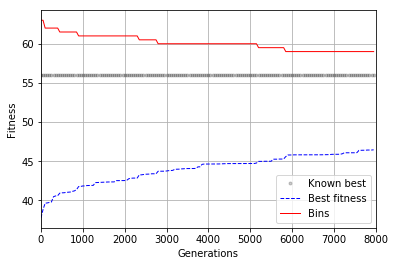

In [13]:
import matplotlib.pyplot as plt

iterations = []
knownBests = []
for i in range(GENERATIONS):
    if i % SAMPLE_RATE == 0:
        iterations.append(i)
        knownBests.append(minBins)


plt.close()

fig = plt.figure()
plt.grid(1)
plt.xlim([0, GENERATIONS])
plt.ion()
plt.xlabel('Generations')
plt.ylabel('Fitness')

plots = []
descriptions = []

bestFitnessOverTime_mean = np.mean(bestFitnessOverTime, axis=0)
bestBinsOverTime_mean = np.mean(bestBinsOverTime, axis=0)

plots.append(plt.plot(iterations, knownBests, 'ko', alpha=0.2, linewidth=0.5, markersize=3)[0])
plots.append(plt.plot(iterations, bestFitnessOverTime_mean, 'b--', linewidth=1, markersize=3)[0])
plots.append(plt.plot(iterations, bestBinsOverTime_mean, 'r-', linewidth=1, markersize=3)[0])
descriptions.append("Known best")
descriptions.append("Best fitness")
descriptions.append("Bins")

plt.legend(plots, descriptions)

plt.show()